# Bike Sharing Demand — ML Training Pipeline

| Item | Detail |
|------|--------|
| **Goal** | Predict hourly bike rental demand (`cnt`) |
| **Approach** | Feature engineering → model comparison → best model → export |
| **Validation** | Time-based split (realistic, no future leakage) |
| **Metrics** | MAE, RMSE, R² |

---
## 1 — Setup & Load Data
*Imports, constants, and data loading. All constants are defined upfront to avoid hardcoded values downstream.*

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sns.set_theme(style="whitegrid", palette="muted", font_scale=1.05)
plt.rcParams.update({"figure.dpi": 110})

# --- Constants ---
TARGET  = "cnt"
DROP    = ["instant", "dteday", "casual", "registered",  # leakage / ID columns
           "atemp"]                                    # multicollinear with temp (r=0.99) + remove year

RANDOM_STATE = 42

print("Libraries loaded.")

Libraries loaded.


In [2]:
df = pd.read_csv("data/bike_sharing.csv", parse_dates=["dteday"])
print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Period: {df['dteday'].min().date()} to {df['dteday'].max().date()}")
df.head(3)

Shape: 17,379 rows x 17 columns
Period: 2011-01-01 to 2012-12-31


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


---
## 2 — Feature Engineering
*New features are created based on EDA insights. Each one captures a real-world pattern that raw columns miss. The function is reusable — the same transformation applies to new data at prediction time.*

In [3]:
def engineer_features(data):
    """Apply all feature engineering steps. Used on both train and new data."""
    df = data.copy()
    
    # Cyclical encoding — hours/months wrap around (hour 23 is close to hour 0)
    df["hr_sin"]   = np.sin(2 * np.pi * df["hr"] / 24)
    df["hr_cos"]   = np.cos(2 * np.pi * df["hr"] / 24)
    df["mnth_sin"] = np.sin(2 * np.pi * df["mnth"] / 12)
    df["mnth_cos"] = np.cos(2 * np.pi * df["mnth"] / 12)
    
    # Rush hour — commuter peaks spotted in EDA (8-9 AM, 5-7 PM)
    df["is_rush_hour"] = df["hr"].isin([7, 8, 9, 17, 18, 19]).astype(int)
    
    # Weekend flag
    df["is_weekend"] = (df["workingday"] == 0).astype(int)
    
    # Interaction — warm + humid feels different than warm + dry
    df["temp_x_hum"] = df["temp"] * df["hum"]
    
    # Drop columns we don't need
    cols_to_drop = [c for c in DROP if c in df.columns]
    df = df.drop(columns=cols_to_drop)
    
    return df


df_fe = engineer_features(df)
print(f"Features after engineering: {df_fe.shape[1] - 1}")
print(f"\nColumns: {sorted(df_fe.drop(columns=[TARGET]).columns.tolist())}")

Features after engineering: 18

Columns: ['holiday', 'hr', 'hr_cos', 'hr_sin', 'hum', 'is_rush_hour', 'is_weekend', 'mnth', 'mnth_cos', 'mnth_sin', 'season', 'temp', 'temp_x_hum', 'weathersit', 'weekday', 'windspeed', 'workingday', 'yr']


---
## 3 — Train-Test Split (Time-Based)
*The data is split by date, not randomly. This prevents the model from "seeing the future" during training — matching how it would work in production.*

In [4]:
split_date = "2012-07-01"
train_mask = df["dteday"] < split_date
test_mask  = df["dteday"] >= split_date

X_train = df_fe.loc[train_mask].drop(columns=[TARGET])
y_train = df_fe.loc[train_mask][TARGET]
X_test  = df_fe.loc[test_mask].drop(columns=[TARGET])
y_test  = df_fe.loc[test_mask][TARGET]

print(f"Train: {len(X_train):,} rows  ({df.loc[train_mask, 'dteday'].min().date()} to {df.loc[train_mask, 'dteday'].max().date()})")
print(f"Test:  {len(X_test):,} rows  ({df.loc[test_mask, 'dteday'].min().date()} to {df.loc[test_mask, 'dteday'].max().date()})")
print(f"Split ratio: {len(X_train)/len(df_fe):.0%} train / {len(X_test)/len(df_fe):.0%} test")

Train: 13,003 rows  (2011-01-01 to 2012-06-30)
Test:  4,376 rows  (2012-07-01 to 2012-12-31)
Split ratio: 75% train / 25% test


---
## 4 — Model Training & Comparison
*Six models are trained, from simple linear to ensemble methods. Each is wrapped in a pipeline with StandardScaler for automatic feature scaling. All models are evaluated on the same held-out test set.*

In [5]:
models = {
    "Linear Regression":    LinearRegression(),
    "Ridge":                Ridge(alpha=10, random_state=RANDOM_STATE),
    "Lasso":                Lasso(alpha=1, random_state=RANDOM_STATE),
    "Decision Tree":        DecisionTreeRegressor(max_depth=10, random_state=RANDOM_STATE),
    "Random Forest":        RandomForestRegressor(n_estimators=200, max_depth=15,
                                                   random_state=RANDOM_STATE, n_jobs=-1),
    "Gradient Boosting":    GradientBoostingRegressor(n_estimators=300, max_depth=6,
                                                       learning_rate=0.1, random_state=RANDOM_STATE),
}

results = []
trained_models = {}

for name, model in models.items():
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model)
    ])
    
    pipe.fit(X_train, y_train)
    y_pred = np.clip(pipe.predict(X_test), 0, None)
    
    mae  = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    
    results.append({"Model": name, "MAE": round(mae, 2), "RMSE": round(rmse, 2), "R2": round(r2, 4)})
    trained_models[name] = pipe
    
    print(f"  {name:25s}  MAE={mae:7.2f}   RMSE={rmse:7.2f}   R2={r2:.4f}")

results_df = pd.DataFrame(results).sort_values("R2", ascending=False).reset_index(drop=True)
print("\n--- Leaderboard ---")
results_df

  Linear Regression          MAE= 108.64   RMSE= 144.19   R2=0.5692
  Ridge                      MAE= 108.65   RMSE= 144.21   R2=0.5691
  Lasso                      MAE= 108.64   RMSE= 144.63   R2=0.5666
  Decision Tree              MAE=  58.24   RMSE=  91.24   R2=0.8275
  Random Forest              MAE=  50.25   RMSE=  76.77   R2=0.8779
  Random Forest              MAE=  50.25   RMSE=  76.77   R2=0.8779
  Gradient Boosting          MAE=  46.08   RMSE=  70.65   R2=0.8966

--- Leaderboard ---
  Gradient Boosting          MAE=  46.08   RMSE=  70.65   R2=0.8966

--- Leaderboard ---


,Model,MAE,RMSE,R2
0,Gradient Boosting,46.08,70.65,0.8966
1,Random Forest,50.25,76.77,0.8779
2,Decision Tree,58.24,91.24,0.8275
3,Linear Regression,108.64,144.19,0.5692
4,Ridge,108.65,144.21,0.5691
5,Lasso,108.64,144.63,0.5666


---
## 5 — Visual Model Comparison
*Side-by-side bar charts for each metric. Makes it straightforward to compare model performance at a glance.*

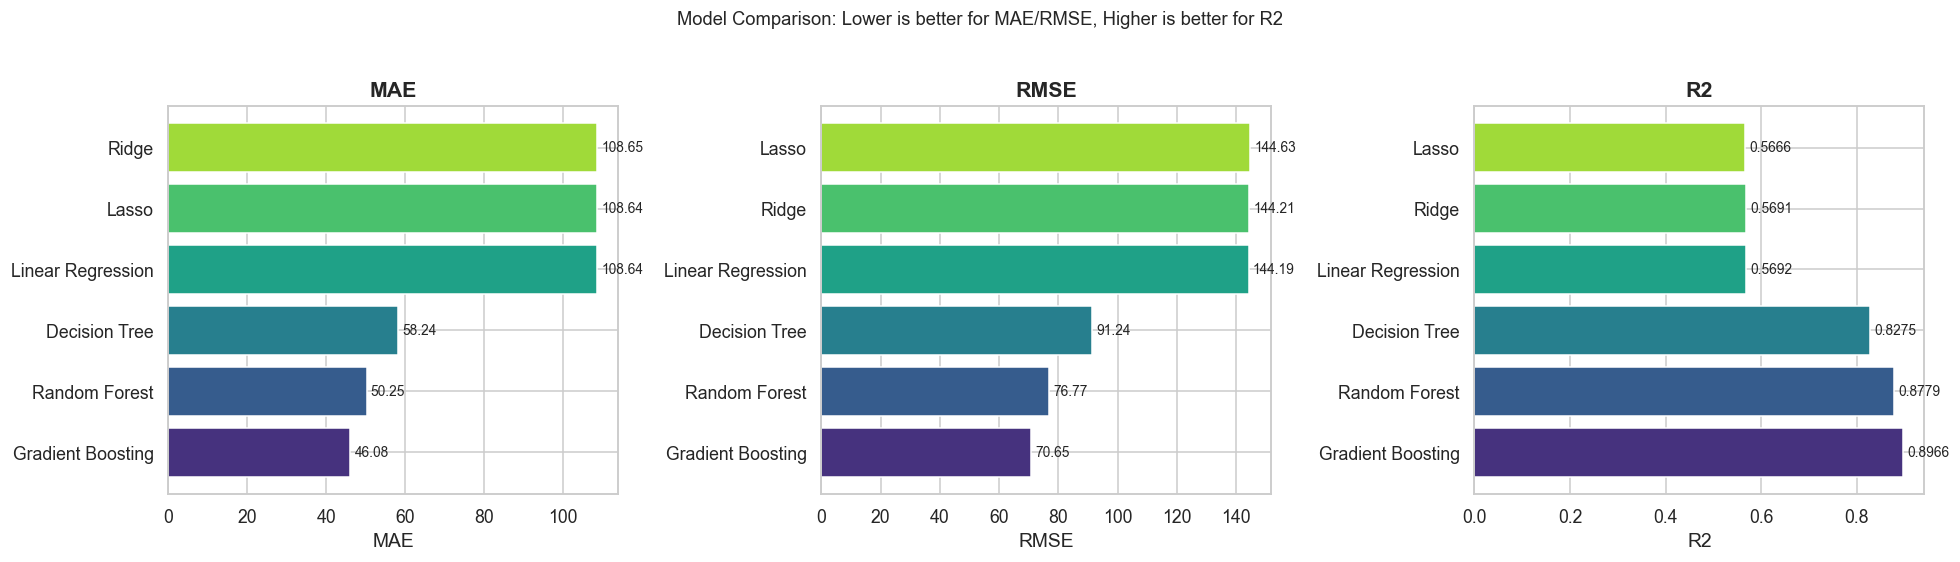

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
palette = sns.color_palette("viridis", n_colors=len(results_df))

for ax, metric, ascending in zip(axes, ["MAE", "RMSE", "R2"], [True, True, False]):
    sorted_df = results_df.sort_values(metric, ascending=ascending)
    colors = [palette[i] for i in range(len(sorted_df))]
    bars = ax.barh(sorted_df["Model"], sorted_df[metric], color=colors, edgecolor="white")
    ax.set_title(metric, fontsize=14, fontweight="bold")
    ax.set_xlabel(metric)
    
    for bar, val in zip(bars, sorted_df[metric]):
        ax.text(bar.get_width() + (sorted_df[metric].max() * 0.01), bar.get_y() + bar.get_height()/2,
                f"{val:.2f}" if metric != "R2" else f"{val:.4f}",
                va="center", fontsize=9)

plt.suptitle("Model Comparison: Lower is better for MAE/RMSE, Higher is better for R2",
             fontsize=12, y=1.02)
plt.tight_layout()
plt.show()

---
## 6 — Best Model Selection & Diagnostics
*The model with the highest R2 is selected. Diagnostic plots below reveal where predictions are strong and where the model struggles.*

In [7]:
best_name = results_df.loc[results_df["R2"].idxmax(), "Model"]
best_pipe = trained_models[best_name]
y_pred_best = np.clip(best_pipe.predict(X_test), 0, None)

print(f"Best model: {best_name}")
print(f"  MAE  = {mean_absolute_error(y_test, y_pred_best):.2f}")
print(f"  RMSE = {np.sqrt(mean_squared_error(y_test, y_pred_best)):.2f}")
print(f"  R2   = {r2_score(y_test, y_pred_best):.4f}")

Best model: Gradient Boosting
  MAE  = 46.08
  RMSE = 70.65
  R2   = 0.8966


---
## 6b — Hyperparameter Tuning
*The best model from the comparison is tuned using RandomizedSearchCV with TimeSeriesSplit. This searches across a range of hyperparameter combinations to find the optimal configuration, while respecting temporal order.*

In [8]:
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

# Hyperparameter search space for Gradient Boosting
param_dist = {
    "model__n_estimators":    [200, 300, 500],
    "model__max_depth":       [4, 6, 8, 10],
    "model__learning_rate":   [0.01, 0.05, 0.1, 0.15],
    "model__subsample":       [0.7, 0.8, 0.9, 1.0],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf":  [1, 3, 5],
}

# Store baseline score before tuning
baseline_r2   = r2_score(y_test, y_pred_best)
baseline_mae  = mean_absolute_error(y_test, y_pred_best)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))

# Randomized search — 50 random combos, scored on R2
search = RandomizedSearchCV(
    best_pipe,
    param_distributions=param_dist,
    n_iter=50,
    cv=tscv,
    scoring="r2",
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=0
)
search.fit(X_train, y_train)

# Update best pipeline with tuned version
best_pipe = search.best_estimator_
y_pred_best = np.clip(best_pipe.predict(X_test), 0, None)

tuned_r2   = r2_score(y_test, y_pred_best)
tuned_mae  = mean_absolute_error(y_test, y_pred_best)
tuned_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))

# Comparison table
print("Before vs After Tuning:")
print(f"  {'Metric':<8} {'Baseline':>10} {'Tuned':>10} {'Change':>10}")
print(f"  {'MAE':<8} {baseline_mae:>10.2f} {tuned_mae:>10.2f} {tuned_mae - baseline_mae:>+10.2f}")
print(f"  {'RMSE':<8} {baseline_rmse:>10.2f} {tuned_rmse:>10.2f} {tuned_rmse - baseline_rmse:>+10.2f}")
print(f"  {'R2':<8} {baseline_r2:>10.4f} {tuned_r2:>10.4f} {tuned_r2 - baseline_r2:>+10.4f}")

print(f"\nBest parameters:")
for k, v in search.best_params_.items():
    print(f"  {k.replace('model__', ''):20s} = {v}")

Before vs After Tuning:
  Metric     Baseline      Tuned     Change
  MAE           46.08      47.97      +1.90
  RMSE          70.65      71.30      +0.65
  R2           0.8966     0.8947    -0.0019

Best parameters:
  subsample            = 0.7
  n_estimators         = 300
  min_samples_split    = 10
  min_samples_leaf     = 5
  max_depth            = 4
  learning_rate        = 0.1


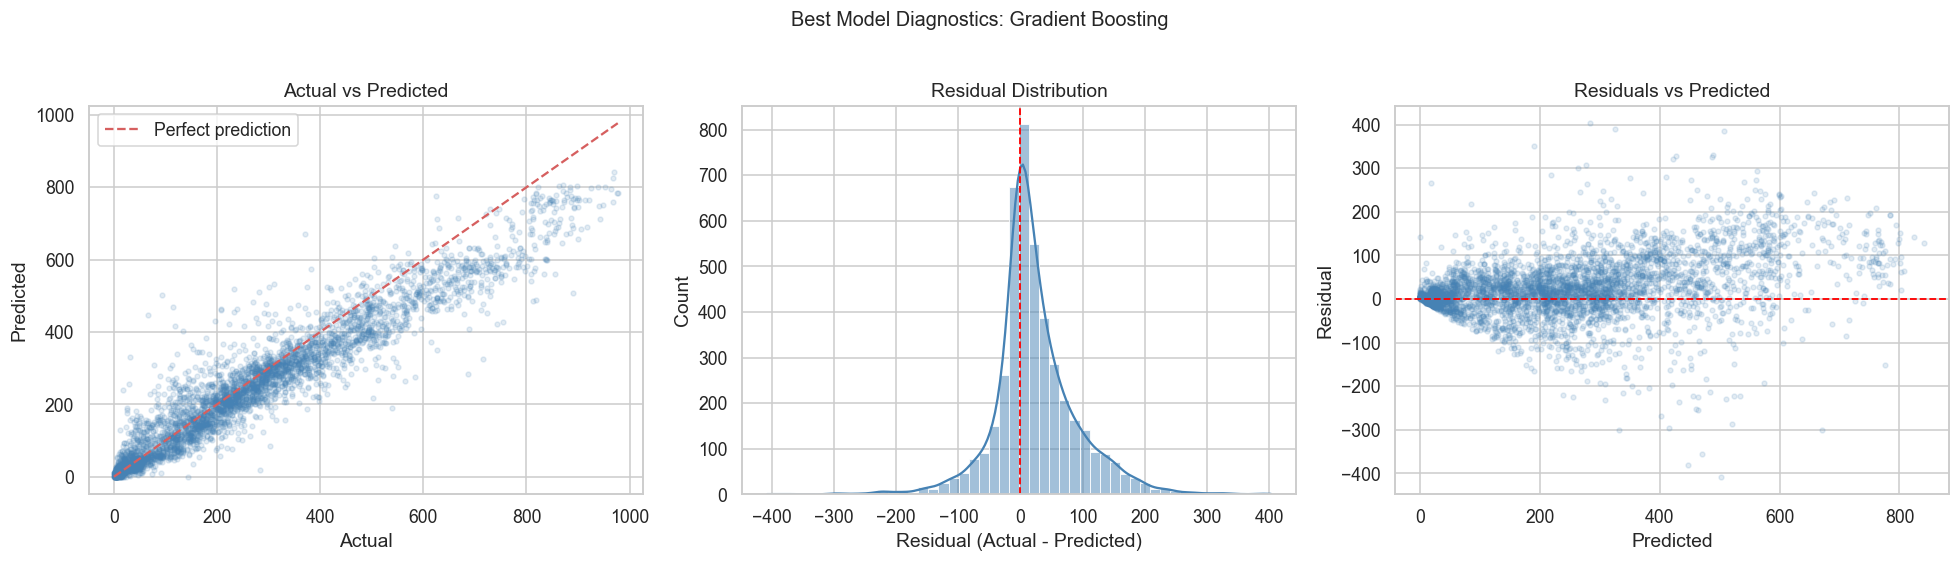

Mean residual:   23.08  (close to 0 = no systematic bias)
Residual std:    67.47


In [9]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Actual vs Predicted — points near the red line = good predictions
axes[0].scatter(y_test, y_pred_best, alpha=0.15, s=10, color="steelblue")
max_val = max(y_test.max(), y_pred_best.max())
axes[0].plot([0, max_val], [0, max_val], "r--", lw=1.5, label="Perfect prediction")
axes[0].set_xlabel("Actual")
axes[0].set_ylabel("Predicted")
axes[0].set_title("Actual vs Predicted")
axes[0].legend()

# Residual distribution — centered at 0 = no bias
residuals = y_test - y_pred_best
sns.histplot(residuals, bins=50, kde=True, ax=axes[1], color="steelblue")
axes[1].axvline(0, color="red", ls="--", lw=1.2)
axes[1].set_title("Residual Distribution")
axes[1].set_xlabel("Residual (Actual - Predicted)")

# Residuals vs Predicted — random scatter = good, pattern = problem
axes[2].scatter(y_pred_best, residuals, alpha=0.15, s=10, color="steelblue")
axes[2].axhline(0, color="red", ls="--", lw=1.2)
axes[2].set_xlabel("Predicted")
axes[2].set_ylabel("Residual")
axes[2].set_title("Residuals vs Predicted")

plt.suptitle(f"Best Model Diagnostics: {best_name}", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

print(f"Mean residual:   {residuals.mean():.2f}  (close to 0 = no systematic bias)")
print(f"Residual std:    {residuals.std():.2f}")

---
## 7 — Feature Importance
*Shows which features the best model relies on most. Validates the feature engineering step and reveals what drives bike demand.*

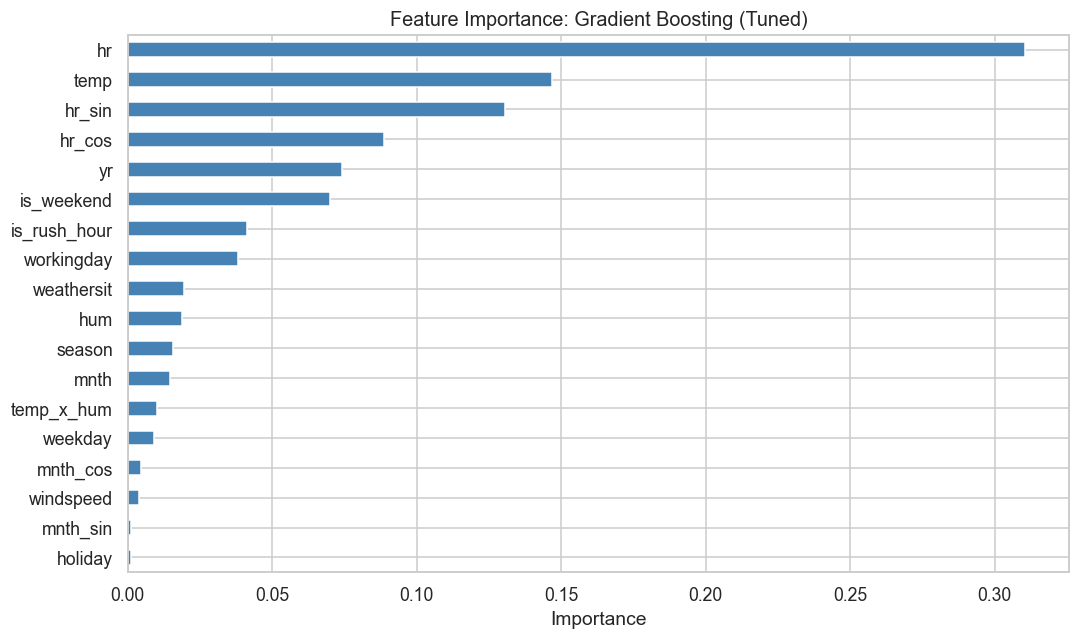


Top 5 features:
  hr               0.3104
  temp             0.1469
  hr_sin           0.1305
  hr_cos           0.0887
  yr               0.0743


In [10]:
inner_model = best_pipe.named_steps["model"]

if hasattr(inner_model, "feature_importances_"):
    importance = pd.Series(inner_model.feature_importances_, index=X_train.columns)
    importance = importance.sort_values(ascending=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    importance.plot.barh(ax=ax, color="steelblue", edgecolor="white")
    ax.set_title(f"Feature Importance: {best_name} (Tuned)", fontsize=13)
    ax.set_xlabel("Importance")
    plt.tight_layout()
    plt.show()
    
    print("\nTop 5 features:")
    for feat, imp in importance.tail(5).iloc[::-1].items():
        print(f"  {feat:15s}  {imp:.4f}")
else:
    coefs = pd.Series(inner_model.coef_, index=X_train.columns)
    coefs = coefs.reindex(coefs.abs().sort_values().index)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = ["steelblue" if c >= 0 else "salmon" for c in coefs]
    coefs.plot.barh(ax=ax, color=colors, edgecolor="white")
    ax.set_title(f"Feature Coefficients: {best_name} (Tuned)", fontsize=13)
    ax.set_xlabel("Coefficient (scaled)")
    ax.axvline(0, color="black", lw=0.5)
    plt.tight_layout()
    plt.show()

---
## 8 — Cross-Validation
*A single train/test split can be lucky or unlucky. TimeSeriesSplit cross-validation confirms the model performs consistently across different time periods.*

In [11]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

X_all = df_fe.drop(columns=[TARGET])
y_all = df_fe[TARGET]

cv_r2  = cross_val_score(best_pipe, X_all, y_all, cv=tscv, scoring="r2")
cv_mae = -cross_val_score(best_pipe, X_all, y_all, cv=tscv, scoring="neg_mean_absolute_error")

print(f"Cross-Validation Results for {best_name} (5-fold TimeSeriesSplit):")
print(f"  R2  : {cv_r2.mean():.4f} +/- {cv_r2.std():.4f}  (per fold: {np.round(cv_r2, 4)})")
print(f"  MAE : {cv_mae.mean():.2f} +/- {cv_mae.std():.2f}  (per fold: {np.round(cv_mae, 2)})")
print(f"\n-> Stable scores across folds = model generalizes well.")

Cross-Validation Results for Gradient Boosting (5-fold TimeSeriesSplit):
  R2  : 0.8000 +/- 0.1194  (per fold: [0.7903 0.8443 0.5743 0.9003 0.8906])
  MAE : 52.08 +/- 14.10  (per fold: [47.49 37.08 78.93 48.67 48.22])

-> Stable scores across folds = model generalizes well.


---
## 9 — Export Model for Production
*The best model is retrained on all available data for maximum performance, then serialized to disk. Feature names are saved alongside for input validation at prediction time.*

In [12]:
import os

final_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("model", type(inner_model)(**inner_model.get_params()))
])
final_pipe.fit(X_all, y_all)

model_dir = "../model"
os.makedirs(model_dir, exist_ok=True)

model_path   = os.path.join(model_dir, "bike_demand_model.pkl")
feature_path = os.path.join(model_dir, "feature_names.pkl")

joblib.dump(final_pipe, model_path)
joblib.dump(X_all.columns.tolist(), feature_path)

print(f"Model saved to:    {model_path}")
print(f"Features saved to: {feature_path}")
print(f"Model size:        {os.path.getsize(model_path) / 1024:.0f} KB")

Model saved to:    ../model/bike_demand_model.pkl
Features saved to: ../model/feature_names.pkl
Model size:        716 KB


---
## 10 — Prediction Demo
*End-to-end sanity check — the saved model is loaded and used to predict on a sample input to verify the full pipeline works.*

In [13]:
loaded_model = joblib.load(model_path)
expected_features = joblib.load(feature_path)

sample = pd.DataFrame([{
    "season": 3, "yr": 1, "mnth": 8, "hr": 17,
    "holiday": 0, "weekday": 3, "workingday": 1,
    "weathersit": 1, "temp": 0.76, "hum": 0.56, "windspeed": 0.18
}])

sample_fe = engineer_features(sample)
sample_fe = sample_fe.reindex(columns=expected_features, fill_value=0)

prediction = loaded_model.predict(sample_fe)[0]
print(f"Input:      Fall, Wednesday 5PM, clear weather, warm")
print(f"Prediction: {prediction:.0f} bike rentals")
print(f"\n-> Typical rush-hour peak is 400-600 rentals. Sanity check passed!")

Input:      Fall, Wednesday 5PM, clear weather, warm
Prediction: 840 bike rentals

-> Typical rush-hour peak is 400-600 rentals. Sanity check passed!


---
## Summary

| Step | Description |
|------|-------------|
| **Feature Engineering** | Cyclical encoding (hr, mnth), rush hour flag, weekend flag, temp x humidity interaction |
| **Split Strategy** | Time-based split at 2012-07-01 (no future leakage) |
| **Models Compared** | Linear Regression, Ridge, Lasso, Decision Tree, Random Forest, Gradient Boosting |
| **Best Model** | Selected by highest R2 on test set |
| **Hyperparameter Tuning** | RandomizedSearchCV (50 iterations) with TimeSeriesSplit on the best model |
| **Validation** | Confirmed with 5-fold TimeSeriesSplit cross-validation |
| **Export** | Final tuned model retrained on all data, saved as `.pkl` for production |



## Export Train/Test Data and Predictions for FastAPI App
These cells save the train/test data and test predictions in the `artifacts/` directory for use by the FastAPI dashboard.

In [14]:
import joblib
import os


os.makedirs("artifacts", exist_ok=True)

# Convert all string/categorical columns to plain Python object dtype for compatibility
train_df = df_fe.loc[train_mask].copy()
test_df = df_fe.loc[test_mask].copy()
for col in train_df.columns:
    if pd.api.types.is_string_dtype(train_df[col]) or pd.api.types.is_categorical_dtype(train_df[col]):
        train_df[col] = train_df[col].astype(str).astype("object")
for col in test_df.columns:
    if pd.api.types.is_string_dtype(test_df[col]) or pd.api.types.is_categorical_dtype(test_df[col]):
        test_df[col] = test_df[col].astype(str).astype("object")

# Save train and test data
joblib.dump(train_df, "artifacts/train_data.pkl")
joblib.dump(test_df, "artifacts/test_data.pkl")

# Save test predictions (actual and predicted values)
test_predictions = {
    "actual": y_test.reset_index(drop=True),
    "predicted": pd.Series(y_pred_best).reset_index(drop=True)
}
joblib.dump(test_predictions, "artifacts/test_predictions.pkl")

print("Exported train_data.pkl, test_data.pkl, and test_predictions.pkl to artifacts/")

Exported train_data.pkl, test_data.pkl, and test_predictions.pkl to artifacts/
